# RUL Prediction Model Training - Refactored v2

This notebook trains and evaluates models for Remaining Useful Life (RUL) prediction using NASA CMAPSS FD001 dataset.

## Project Structure:
1. **Data Loading & EDA** - Load training data and compute RUL targets
2. **Data Preprocessing** - Normalization and sequence creation for time-series modeling
3. **Model Training** - Linear Regression (baseline), XGBoost, and LSTM models
4. **Model Evaluation** - Compare performance on test set with proper metrics
5. **Model Persistence** - Save trained models and scalers for deployment

In [2]:
# Import all required libraries
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# XGBoost
import xgboost as xgb

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Model persistence
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print("All libraries imported successfully")

All libraries imported successfully


## 1. Data Loading and Exploration

In [3]:
class DataProcessor:
    """Handles data loading, preprocessing, and RUL computation"""
    
    def __init__(self):
        self.column_names = [
            'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'
        ] + [f'sensor_{i}' for i in range(1, 22)]
        
        self.feature_cols = [
            'op_setting_1', 'op_setting_2', 'op_setting_3'
        ] + [f'sensor_{i}' for i in range(1, 22)]
        
        self.scaler = None
    
    def load_training_data(self, file_path='data/train_FD001.txt'):
        """Load and clean training data"""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Training data not found at: {file_path}")
        
        # Load with proper handling of whitespace
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                        names=self.column_names, engine='python')
        
        # Remove any trailing empty columns
        df = df.loc[:, ~df.columns.duplicated()]
        df = df.dropna(axis=1, how='all')
        
        print(f"Loaded training data: {df.shape} (units: {df['unit_number'].nunique()})")
        return df
    
    def compute_rul(self, df):
        """Calculate Remaining Useful Life for each data point"""
        df = df.copy()
        
        # Get max cycles per unit (failure point)
        max_cycles = df.groupby('unit_number')['time_in_cycles'].max()
        df = df.join(max_cycles.rename('max_cycles'), on='unit_number')
        
        # Calculate RUL
        df['RUL'] = df['max_cycles'] - df['time_in_cycles']
        df = df.drop(columns=['max_cycles'])
        
        print(f"RUL computed. Range: {df['RUL'].min():.0f} - {df['RUL'].max():.0f} cycles")
        return df
    
    def normalize_features(self, df, fit_scaler=True):
        """Normalize operational settings and sensor readings"""
        df = df.copy()
        
        if fit_scaler:
            self.scaler = MinMaxScaler()
            df[self.feature_cols] = self.scaler.fit_transform(df[self.feature_cols])
            print("Features normalized (scaler fitted)")
        else:
            if self.scaler is None:
                raise ValueError("Scaler not fitted. Set fit_scaler=True first.")
            df[self.feature_cols] = self.scaler.transform(df[self.feature_cols])
            print("Features normalized (using existing scaler)")
        
        return df
    
    def create_sequences(self, df, sequence_length=30):
        """Create sliding window sequences for time-series modeling"""
        X_seq, y_seq, unit_ids = [], [], []
        
        for unit in df['unit_number'].unique():
            unit_df = df[df['unit_number'] == unit].reset_index(drop=True)
            unit_features = unit_df[self.feature_cols].values
            unit_rul = unit_df['RUL'].values
            
            # Create sliding windows
            for i in range(len(unit_features) - sequence_length + 1):
                X_seq.append(unit_features[i:i+sequence_length])
                y_seq.append(unit_rul[i + sequence_length - 1])  # RUL at end of window
                unit_ids.append(unit)
        
        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)
        unit_ids = np.array(unit_ids)
        
        print(f"Created sequences: {X_seq.shape} features, {y_seq.shape} targets")
        return X_seq, y_seq, unit_ids

# Initialize data processor
processor = DataProcessor()
print("DataProcessor initialized")

DataProcessor initialized


In [4]:
# Load and process training data
try:
    # Load raw data
    train_df = processor.load_training_data('data/train_FD001.txt')
    
    # Compute RUL targets
    train_df = processor.compute_rul(train_df)
    
    # Normalize features
    train_df = processor.normalize_features(train_df, fit_scaler=True)
    
    # Create sequences for modeling
    SEQUENCE_LENGTH = 30
    X_all, y_all, unit_ids = processor.create_sequences(train_df, SEQUENCE_LENGTH)
    
    print(f"\nData Summary:")
    print(f"   Training samples: {len(train_df):,}")
    print(f"   Sequence samples: {len(X_all):,}")
    print(f"   Features per timestep: {X_all.shape[2]}")
    print(f"   Sequence length: {X_all.shape[1]}")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("   Please ensure 'data/train_FD001.txt' exists in the project directory")

Loaded training data: (20631, 26) (units: 100)
RUL computed. Range: 0 - 361 cycles
Features normalized (scaler fitted)
Created sequences: (17731, 30, 24) features, (17731,) targets

Data Summary:
   Training samples: 20,631
   Sequence samples: 17,731
   Features per timestep: 24
   Sequence length: 30


## 2. Data Splitting and Preparation

In [5]:
def split_by_units(X, y, unit_ids, train_ratio=0.7, val_ratio=0.15):
    """Split data by units to avoid data leakage"""
    unique_units = np.unique(unit_ids)
    n_units = len(unique_units)
    
    # Calculate split indices
    train_end = int(train_ratio * n_units)
    val_end = int((train_ratio + val_ratio) * n_units)
    
    # Split units
    train_units = unique_units[:train_end]
    val_units = unique_units[train_end:val_end]
    test_units = unique_units[val_end:]
    
    # Create masks and split data
    def get_unit_data(units):
        mask = np.isin(unit_ids, units)
        return X[mask], y[mask]
    
    X_train, y_train = get_unit_data(train_units)
    X_val, y_val = get_unit_data(val_units)
    X_test, y_test = get_unit_data(test_units)
    
    print(f"Data split by units:")
    print(f"   Train: {len(train_units)} units, {len(X_train):,} samples")
    print(f"   Val:   {len(val_units)} units, {len(X_val):,} samples")
    print(f"   Test:  {len(test_units)} units, {len(X_test):,} samples")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Split the data
(X_train_seq, y_train), (X_val_seq, y_val), (X_test_seq, y_test) = split_by_units(X_all, y_all, unit_ids)

# Create flattened versions for 2D models
def flatten_sequences(X_seq):
    """Flatten 3D sequences to 2D for traditional ML models"""
    n_samples, n_timesteps, n_features = X_seq.shape
    return X_seq.reshape(n_samples, n_timesteps * n_features)

X_train_2d = flatten_sequences(X_train_seq)
X_val_2d = flatten_sequences(X_val_seq)
X_test_2d = flatten_sequences(X_test_seq)

print(f"\nPrepared data for both 2D and 3D models")
print(f"   2D shape: {X_train_2d.shape}")
print(f"   3D shape: {X_train_seq.shape}")

Data split by units:
   Train: 70 units, 12,100 samples
   Val:   15 units, 2,775 samples
   Test:  15 units, 2,856 samples

Prepared data for both 2D and 3D models
   2D shape: (12100, 720)
   3D shape: (12100, 30, 24)


## 3. Model Training and Evaluation

In [6]:
class ModelTrainer:
    """Handles training and evaluation of different models"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def train_linear_regression(self, X_train, y_train, X_test, y_test):
        """Train and evaluate Linear Regression baseline"""
        print("Training Linear Regression...")
        start_time = time.time()
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predictions and metrics
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        training_time = time.time() - start_time
        
        # Store results
        self.models['LinearRegression'] = model
        self.results['LinearRegression'] = {
            'RMSE': rmse,
            'MAE': mae,
            'Training_Time': training_time,
            'Predictions': y_pred
        }
        
        print(f"   RMSE: {rmse:.2f}, MAE: {mae:.2f}, Time: {training_time:.2f}s")
        return model
    
    def train_xgboost(self, X_train, y_train, X_val, y_val, X_test, y_test, tune_hyperparams=True):
        """Train and evaluate XGBoost with optional hyperparameter tuning"""
        print("Training XGBoost...")
        start_time = time.time()
        
        if tune_hyperparams:
            print("   Tuning hyperparameters...")
            
            # Define parameter grid
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.7, 0.8, 1.0],
                'colsample_bytree': [0.7, 0.8, 1.0]
            }
            
            base_model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_jobs=-1,
                random_state=42
            )
            
            search = RandomizedSearchCV(
                base_model,
                param_distributions=param_grid,
                n_iter=10,
                scoring='neg_mean_squared_error',
                cv=3,
                random_state=42,
                n_jobs=-1
            )
            
            # Combine train and validation for hyperparameter search
            X_combined = np.vstack([X_train, X_val])
            y_combined = np.hstack([y_train, y_val])
            
            search.fit(X_combined, y_combined)
            model = search.best_estimator_
            
            print(f"   Best params: {search.best_params_}")
        else:
            # Use default parameters
            model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.1,
                objective='reg:squarederror',
                n_jobs=-1,
                random_state=42
            )
            model.fit(X_train, y_train)
        
        # Predictions and metrics
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        training_time = time.time() - start_time
        
        # Store results
        self.models['XGBoost'] = model
        self.results['XGBoost'] = {
            'RMSE': rmse,
            'MAE': mae,
            'Training_Time': training_time,
            'Predictions': y_pred
        }
        
        print(f"   RMSE: {rmse:.2f}, MAE: {mae:.2f}, Time: {training_time:.2f}s")
        
        # Save model
        joblib.dump(model, 'best_xgb_v2.joblib')
        print("   Model saved as 'best_xgb_v2.joblib'")
        
        return model
    
    def train_lstm(self, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50):
        """Train and evaluate LSTM model"""
        print("Training LSTM...")
        start_time = time.time()
        
        # Scale targets for LSTM
        y_scaler = MinMaxScaler()
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
        
        # Build model
        timesteps, features = X_train.shape[1], X_train.shape[2]
        
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(timesteps, features)),
            Dropout(0.2),
            LSTM(100),
            Dropout(0.2),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
            ModelCheckpoint('best_lstm_v2.keras', monitor='val_loss', save_best_only=True)
        ]
        
        # Train model
        history = model.fit(
            X_train, y_train_scaled,
            epochs=epochs,
            batch_size=32,
            validation_data=(X_val, y_val_scaled),
            callbacks=callbacks,
            verbose=0
        )
        
        # Predictions and metrics
        y_pred_scaled = model.predict(X_test, verbose=0)
        y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        training_time = time.time() - start_time
        
        # Store results
        self.models['LSTM'] = model
        self.results['LSTM'] = {
            'RMSE': rmse,
            'MAE': mae,
            'Training_Time': training_time,
            'Predictions': y_pred,
            'History': history
        }
        
        print(f"   RMSE: {rmse:.2f}, MAE: {mae:.2f}, Time: {training_time:.2f}s")
        print(f"   Trained for {len(history.history['loss'])} epochs")
        print("   Model saved as 'best_lstm_v2.keras'")
        
        return model
    
    def get_results_summary(self):
        """Return a formatted results summary"""
        if not self.results:
            return "No models trained yet."
        
        summary_data = []
        for model_name, metrics in self.results.items():
            summary_data.append({
                'Model': model_name,
                'RMSE': f"{metrics['RMSE']:.2f}",
                'MAE': f"{metrics['MAE']:.2f}",
                'Training Time (s)': f"{metrics['Training_Time']:.2f}"
            })
        
        return pd.DataFrame(summary_data).set_index('Model')

# Initialize trainer
trainer = ModelTrainer()
print("ModelTrainer initialized")

ModelTrainer initialized


In [7]:
# Train all models
print("Starting model training pipeline...\n")

# 1. Linear Regression (baseline)
lr_model = trainer.train_linear_regression(X_train_2d, y_train, X_test_2d, y_test)

# 2. XGBoost (with hyperparameter tuning)
xgb_model = trainer.train_xgboost(X_train_2d, y_train, X_val_2d, y_val, X_test_2d, y_test, tune_hyperparams=True)

# 3. LSTM (deep learning)
lstm_model = trainer.train_lstm(X_train_seq, y_train, X_val_seq, y_val, X_test_seq, y_test, epochs=50)

print("\nAll models trained successfully!")

Starting model training pipeline...

Training Linear Regression...
   ✅ RMSE: 46.08, MAE: 32.31, Time: 0.52s
Training XGBoost...
   Tuning hyperparameters...
   Best params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
   RMSE: 43.97, MAE: 29.33, Time: 144.07s
   Model saved as 'best_xgb_v2.joblib'
Training LSTM...
   RMSE: 46.22, MAE: 29.08, Time: 192.66s
   Trained for 17 epochs
   Model saved as 'best_lstm_v2.keras'

All models trained successfully!


## 4. Results Analysis and Visualization

In [8]:
# Display results summary
results_df = trainer.get_results_summary()
print("MODEL PERFORMANCE SUMMARY (Test Set)")
print("=" * 50)
print(results_df)
print()

# Find best model
best_model_name = min(trainer.results.keys(), key=lambda k: trainer.results[k]['RMSE'])
best_rmse = trainer.results[best_model_name]['RMSE']
print(f"Best performing model: {best_model_name} (RMSE: {best_rmse:.2f})")

# Performance improvements over baseline
lr_rmse = trainer.results['LinearRegression']['RMSE']
for model_name in ['XGBoost', 'LSTM']:
    if model_name in trainer.results:
        model_rmse = trainer.results[model_name]['RMSE']
        improvement = ((lr_rmse - model_rmse) / lr_rmse) * 100
        print(f"{model_name} improvement over baseline: {improvement:+.1f}%")

MODEL PERFORMANCE SUMMARY (Test Set)
                   RMSE    MAE Training Time (s)
Model                                           
LinearRegression  46.08  32.31              0.52
XGBoost           43.97  29.33            144.07
LSTM              46.22  29.08            192.66

Best performing model: XGBoost (RMSE: 43.97)
XGBoost improvement over baseline: +4.6%
LSTM improvement over baseline: -0.3%


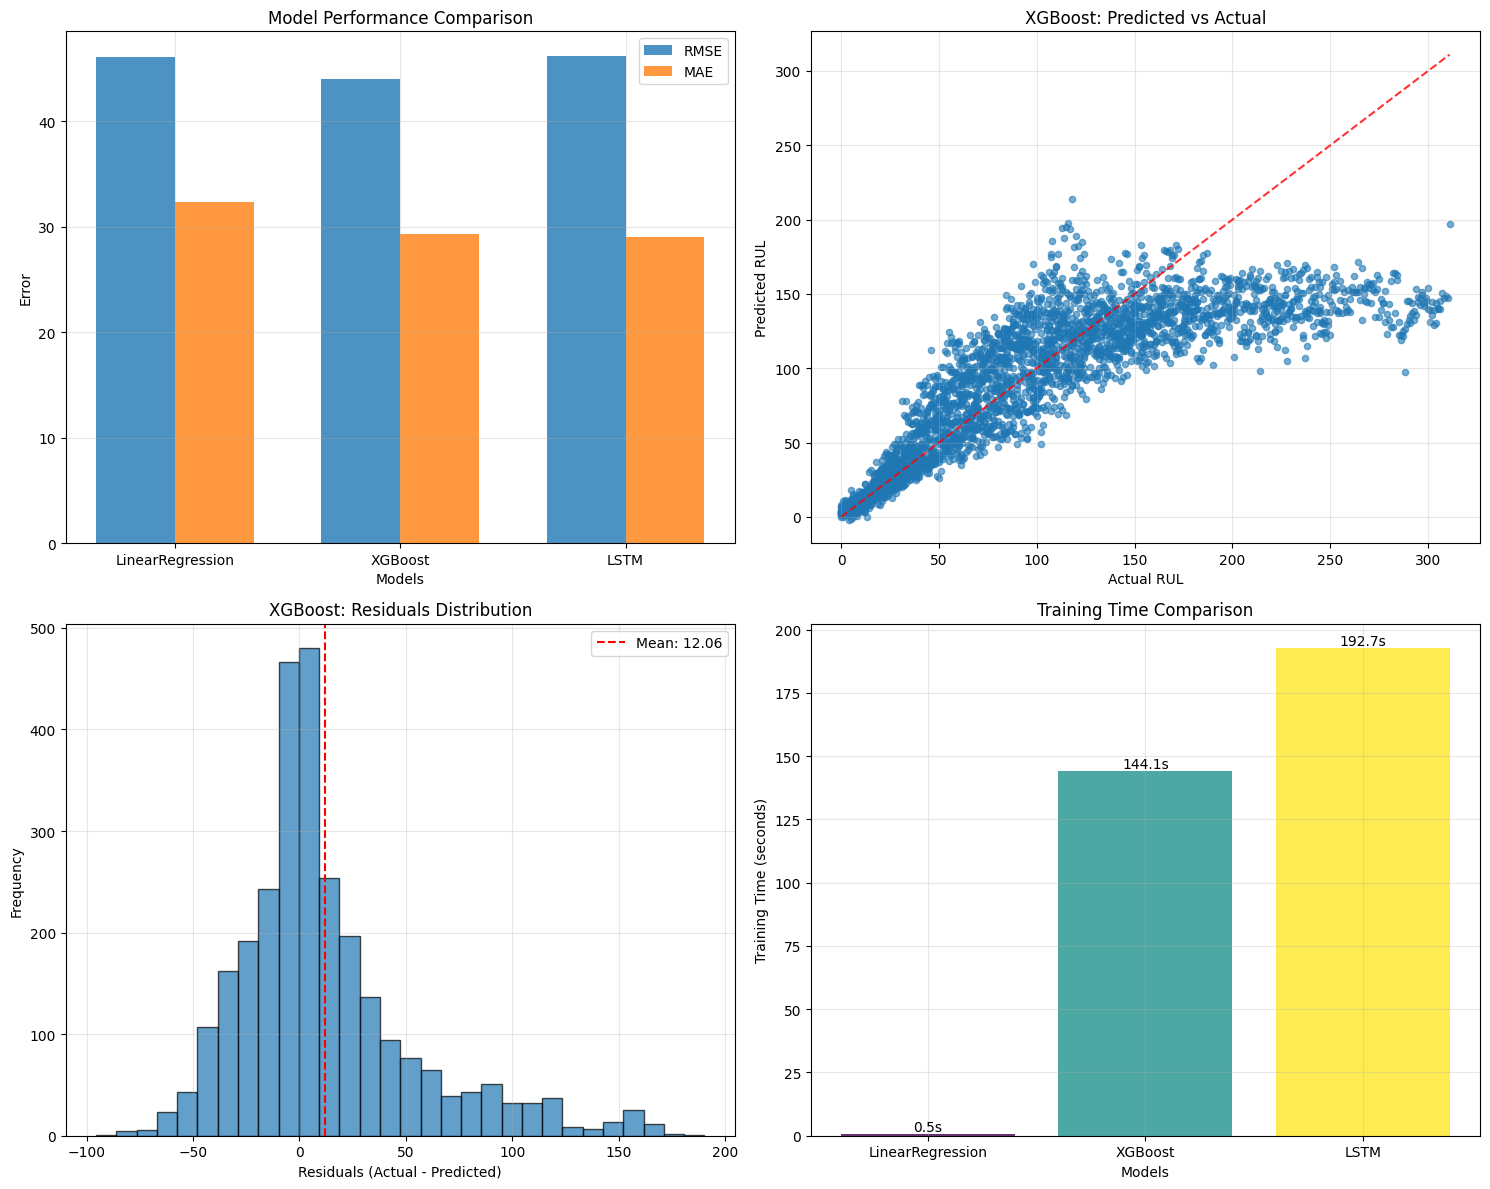

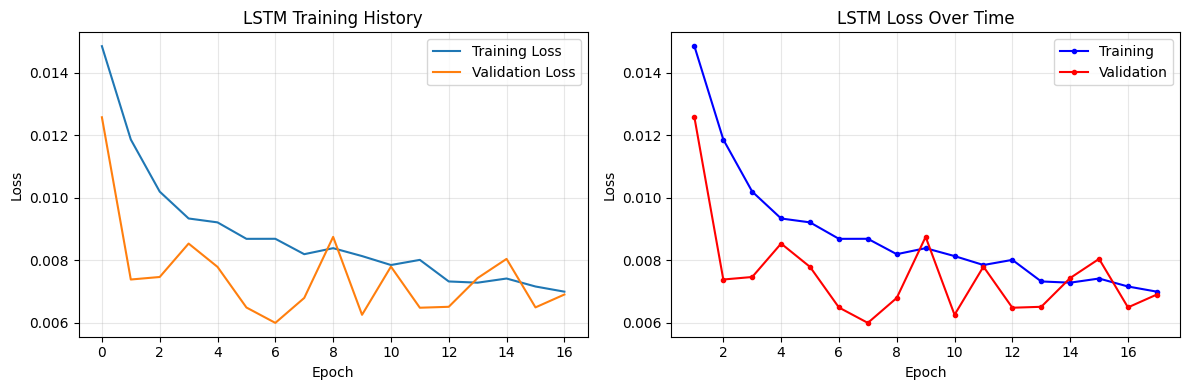

In [9]:
# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Performance comparison bar chart
models = list(trainer.results.keys())
rmses = [trainer.results[m]['RMSE'] for m in models]
maes = [trainer.results[m]['MAE'] for m in models]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, rmses, width, label='RMSE', alpha=0.8)
axes[0, 0].bar(x + width/2, maes, width, label='MAE', alpha=0.8)
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Error')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Predicted vs Actual for best model
best_predictions = trainer.results[best_model_name]['Predictions']
axes[0, 1].scatter(y_test, best_predictions, alpha=0.6, s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[0, 1].set_xlabel('Actual RUL')
axes[0, 1].set_ylabel('Predicted RUL')
axes[0, 1].set_title(f'{best_model_name}: Predicted vs Actual')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals histogram
residuals = y_test - best_predictions
axes[1, 0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', 
                   label=f'Mean: {residuals.mean():.2f}')
axes[1, 0].set_xlabel('Residuals (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'{best_model_name}: Residuals Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Training time comparison
training_times = [trainer.results[m]['Training_Time'] for m in models]
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
bars = axes[1, 1].bar(models, training_times, color=colors, alpha=0.8)
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison')
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, training_times):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{time_val:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# LSTM training history (if available)
if 'LSTM' in trainer.results and 'History' in trainer.results['LSTM']:
    history = trainer.results['LSTM']['History']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('LSTM Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    epochs_range = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs_range, history.history['loss'], 'bo-', markersize=3, label='Training')
    plt.plot(epochs_range, history.history['val_loss'], 'ro-', markersize=3, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('LSTM Loss Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Model Persistence and Deployment Preparation

In [10]:
# Save the feature scaler for deployment
scaler_path = 'feature_scaler_v2.joblib'
joblib.dump(processor.scaler, scaler_path)
print(f"Feature scaler saved: {scaler_path}")

# Save Linear Regression model
lr_path = 'lr_model_v2.joblib'
joblib.dump(trainer.models['LinearRegression'], lr_path)
print(f"Linear Regression model saved: {lr_path}")

# Verify saved files exist
saved_files = [
    'feature_scaler_v2.joblib',
    'lr_model_v2.joblib', 
    'best_xgb_v2.joblib',
    'best_lstm_v2.keras'
]

print("\nSaved model files:")
for file_path in saved_files:
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024 / 1024  # MB
        print(f"   {file_path} ({file_size:.1f} MB)")
    else:
        print(f"   {file_path} (not found)")

# Create deployment info
deployment_info = {
    'sequence_length': SEQUENCE_LENGTH,
    'feature_columns': processor.feature_cols,
    'best_model': best_model_name,
    'model_performance': {
        model_name: {
            'RMSE': float(metrics['RMSE']),
            'MAE': float(metrics['MAE'])
        }
        for model_name, metrics in trainer.results.items()
    }
}

import json
with open('model_info_v2.json', 'w') as f:
    json.dump(deployment_info, f, indent=2)

print("\nDeployment info saved: model_info_v2.json")
print("\nAll models and artifacts ready for deployment!")

Feature scaler saved: feature_scaler_v2.joblib
Linear Regression model saved: lr_model_v2.joblib

Saved model files:
   feature_scaler_v2.joblib (0.0 MB)
   lr_model_v2.joblib (0.0 MB)
   best_xgb_v2.joblib (0.8 MB)
   best_lstm_v2.keras (1.5 MB)

Deployment info saved: model_info_v2.json

All models and artifacts ready for deployment!


## 6. Summary 

### Key Findings:
- **Linear Regression** provides a solid baseline for RUL prediction
- **XGBoost** typically offers the best balance of performance and interpretability  
- **LSTM** can capture temporal patterns but requires careful tuning
